In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:11<00:00,  3.25it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 232/232 [00:04<00:00, 49.39it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:23<00:00,  2.90it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 243/243 [00:02<00:00, 113.27it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 10/2500 [00:00<01:27, 28.56it/s]

Epoch 10/2500, Loss: 0.5789
Test Accuracy at Epoch 10: 65.00%
Test F1-score at Epoch 10: 0.6509
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.66      0.63      0.65       194
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380

New best model saved with F1-score 0.6509 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.66      0.63      0.65       194
non_infringement       0.64      0.67      0.65       186

        accuracy                           0.65       380
       macro avg       0.65      0.65      0.65       380
    weighted avg       0.65      0.65      0.65       380



Training Epochs:   1%|          | 25/2500 [00:00<01:12, 34.05it/s]

Epoch 20/2500, Loss: 0.3876
Test Accuracy at Epoch 20: 66.58%
Test F1-score at Epoch 20: 0.6276
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.65      0.75      0.70       194
non_infringement       0.69      0.58      0.63       186

        accuracy                           0.67       380
       macro avg       0.67      0.66      0.66       380
    weighted avg       0.67      0.67      0.66       380



Training Epochs:   1%|▏         | 33/2500 [00:01<01:21, 30.21it/s]

Epoch 30/2500, Loss: 0.3413
Test Accuracy at Epoch 30: 67.89%
Test F1-score at Epoch 30: 0.6667
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.68      0.70      0.69       194
non_infringement       0.68      0.66      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380

New best model saved with F1-score 0.6667 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.68      0.70      0.69       194
non_infringement       0.68      0.66      0.67       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.68       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:   2%|▏         | 45/2500 [00:01<01:22, 29.82it/s]

Epoch 40/2500, Loss: 0.3165
Test Accuracy at Epoch 40: 69.74%
Test F1-score at Epoch 40: 0.6950
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380

New best model saved with F1-score 0.6950 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.71      0.69      0.70       194
non_infringement       0.69      0.70      0.69       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:   2%|▏         | 53/2500 [00:01<01:26, 28.41it/s]

Epoch 50/2500, Loss: 0.2842
Test Accuracy at Epoch 50: 70.53%
Test F1-score at Epoch 50: 0.7186
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       194
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380

New best model saved with F1-score 0.7186 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       194
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:   2%|▏         | 62/2500 [00:02<01:28, 27.48it/s]

Epoch 60/2500, Loss: 0.2620
Test Accuracy at Epoch 60: 71.58%
Test F1-score at Epoch 60: 0.7216
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       194
non_infringement       0.69      0.75      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380

New best model saved with F1-score 0.7216 at epoch 60
Best Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       194
non_infringement       0.69      0.75      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:   3%|▎         | 72/2500 [00:02<01:44, 23.19it/s]

Epoch 70/2500, Loss: 0.2414
Test Accuracy at Epoch 70: 71.05%
Test F1-score at Epoch 70: 0.7135
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.73      0.69      0.71       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:   3%|▎         | 80/2500 [00:02<01:28, 27.50it/s]

Epoch 80/2500, Loss: 0.2259
Test Accuracy at Epoch 80: 72.89%
Test F1-score at Epoch 80: 0.7379
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

New best model saved with F1-score 0.7379 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.76      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:   4%|▎         | 93/2500 [00:03<01:30, 26.57it/s]

Epoch 90/2500, Loss: 0.2774
Test Accuracy at Epoch 90: 71.84%
Test F1-score at Epoch 90: 0.7679
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.91      0.49      0.64       194
non_infringement       0.64      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.72      0.71       380
    weighted avg       0.78      0.72      0.70       380

New best model saved with F1-score 0.7679 at epoch 90
Best Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.91      0.49      0.64       194
non_infringement       0.64      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.72      0.71       380
    weighted avg       0.78      0.72      0.70       380



Training Epochs:   4%|▍         | 101/2500 [00:03<01:19, 30.31it/s]

Epoch 100/2500, Loss: 0.2369
Test Accuracy at Epoch 100: 69.74%
Test F1-score at Epoch 100: 0.6608
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.67      0.79      0.73       194
non_infringement       0.73      0.60      0.66       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.70      0.69       380



Training Epochs:   5%|▍         | 115/2500 [00:03<01:10, 33.77it/s]

Epoch 110/2500, Loss: 0.2370
Test Accuracy at Epoch 110: 73.16%
Test F1-score at Epoch 110: 0.7385
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:   5%|▍         | 124/2500 [00:04<01:10, 33.53it/s]

Epoch 120/2500, Loss: 0.2116
Test Accuracy at Epoch 120: 73.68%
Test F1-score at Epoch 120: 0.7449
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   5%|▌         | 133/2500 [00:04<01:14, 31.65it/s]

Epoch 130/2500, Loss: 0.1982
Test Accuracy at Epoch 130: 72.37%
Test F1-score at Epoch 130: 0.7287
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       194
non_infringement       0.70      0.76      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:   6%|▌         | 142/2500 [00:04<01:07, 34.75it/s]

Epoch 140/2500, Loss: 0.1843
Test Accuracy at Epoch 140: 72.37%
Test F1-score at Epoch 140: 0.7301
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       194
non_infringement       0.70      0.76      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:   6%|▌         | 156/2500 [00:05<01:05, 35.87it/s]

Epoch 150/2500, Loss: 0.1717
Test Accuracy at Epoch 150: 72.89%
Test F1-score at Epoch 150: 0.7339
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.75      0.70      0.72       194
non_infringement       0.71      0.76      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:   7%|▋         | 164/2500 [00:05<01:07, 34.52it/s]

Epoch 160/2500, Loss: 0.1635
Test Accuracy at Epoch 160: 76.05%
Test F1-score at Epoch 160: 0.7742
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380

New best model saved with F1-score 0.7742 at epoch 160
Best Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.82      0.69      0.75       194
non_infringement       0.72      0.84      0.77       186

        accuracy                           0.76       380
       macro avg       0.77      0.76      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:   7%|▋         | 173/2500 [00:05<01:17, 29.88it/s]

Epoch 170/2500, Loss: 0.3387
Test Accuracy at Epoch 170: 72.11%
Test F1-score at Epoch 170: 0.7696
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.92      0.50      0.65       194
non_infringement       0.65      0.95      0.77       186

        accuracy                           0.72       380
       macro avg       0.78      0.73      0.71       380
    weighted avg       0.78      0.72      0.71       380



Training Epochs:   7%|▋         | 182/2500 [00:05<01:07, 34.11it/s]

Epoch 180/2500, Loss: 0.2557
Test Accuracy at Epoch 180: 73.68%
Test F1-score at Epoch 180: 0.7449
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   8%|▊         | 196/2500 [00:06<01:06, 34.55it/s]

Epoch 190/2500, Loss: 0.2110
Test Accuracy at Epoch 190: 77.11%
Test F1-score at Epoch 190: 0.7852
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.83      0.69      0.75       194
non_infringement       0.73      0.85      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

New best model saved with F1-score 0.7852 at epoch 190
Best Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.83      0.69      0.75       194
non_infringement       0.73      0.85      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:   8%|▊         | 204/2500 [00:06<01:10, 32.51it/s]

Epoch 200/2500, Loss: 0.1779
Test Accuracy at Epoch 200: 75.00%
Test F1-score at Epoch 200: 0.7607
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   9%|▊         | 213/2500 [00:06<01:15, 30.44it/s]

Epoch 210/2500, Loss: 0.1625
Test Accuracy at Epoch 210: 72.63%
Test F1-score at Epoch 210: 0.7263
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.74      0.71      0.73       194
non_infringement       0.71      0.74      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:   9%|▉         | 222/2500 [00:07<01:11, 32.05it/s]

Epoch 220/2500, Loss: 0.1502
Test Accuracy at Epoch 220: 75.00%
Test F1-score at Epoch 220: 0.7595
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:   9%|▉         | 235/2500 [00:07<01:05, 34.84it/s]

Epoch 230/2500, Loss: 0.1411
Test Accuracy at Epoch 230: 74.74%
Test F1-score at Epoch 230: 0.7563
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  10%|▉         | 243/2500 [00:07<01:07, 33.45it/s]

Epoch 240/2500, Loss: 0.1328
Test Accuracy at Epoch 240: 75.00%
Test F1-score at Epoch 240: 0.7595
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  10%|█         | 252/2500 [00:08<01:11, 31.38it/s]

Epoch 250/2500, Loss: 0.1264
Test Accuracy at Epoch 250: 74.74%
Test F1-score at Epoch 250: 0.7563
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  11%|█         | 266/2500 [00:08<01:06, 33.54it/s]

Epoch 260/2500, Loss: 0.1210
Test Accuracy at Epoch 260: 74.47%
Test F1-score at Epoch 260: 0.7544
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  11%|█         | 275/2500 [00:08<00:59, 37.17it/s]

Epoch 270/2500, Loss: 0.1255
Test Accuracy at Epoch 270: 73.95%
Test F1-score at Epoch 270: 0.7603
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.81      0.64      0.71       194
non_infringement       0.69      0.84      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  11%|█         | 280/2500 [00:08<01:05, 33.72it/s]

Epoch 280/2500, Loss: 0.4106
Test Accuracy at Epoch 280: 64.47%
Test F1-score at Epoch 280: 0.5603
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.61      0.82      0.70       194
non_infringement       0.71      0.46      0.56       186

        accuracy                           0.64       380
       macro avg       0.66      0.64      0.63       380
    weighted avg       0.66      0.64      0.63       380



Training Epochs:  12%|█▏        | 293/2500 [00:09<01:13, 30.10it/s]

Epoch 290/2500, Loss: 0.2038
Test Accuracy at Epoch 290: 68.68%
Test F1-score at Epoch 290: 0.6448
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.66      0.79      0.72       194
non_infringement       0.72      0.58      0.64       186

        accuracy                           0.69       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.69      0.68       380



Training Epochs:  12%|█▏        | 306/2500 [00:09<01:06, 33.13it/s]

Epoch 300/2500, Loss: 0.2092
Test Accuracy at Epoch 300: 73.95%
Test F1-score at Epoch 300: 0.7494
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  13%|█▎        | 315/2500 [00:09<01:00, 36.25it/s]

Epoch 310/2500, Loss: 0.1765
Test Accuracy at Epoch 310: 77.11%
Test F1-score at Epoch 310: 0.7862
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.75       194
non_infringement       0.72      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380

New best model saved with F1-score 0.7862 at epoch 310
Best Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.75       194
non_infringement       0.72      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



Training Epochs:  13%|█▎        | 325/2500 [00:10<01:02, 34.77it/s]

Epoch 320/2500, Loss: 0.1500
Test Accuracy at Epoch 320: 72.11%
Test F1-score at Epoch 320: 0.7240
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       194
non_infringement       0.70      0.75      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  13%|█▎        | 334/2500 [00:10<01:08, 31.69it/s]

Epoch 330/2500, Loss: 0.1331
Test Accuracy at Epoch 330: 72.11%
Test F1-score at Epoch 330: 0.7240
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       194
non_infringement       0.70      0.75      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  14%|█▎        | 343/2500 [00:10<01:02, 34.65it/s]

Epoch 340/2500, Loss: 0.1242
Test Accuracy at Epoch 340: 72.11%
Test F1-score at Epoch 340: 0.7254
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.74      0.69      0.72       194
non_infringement       0.70      0.75      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  14%|█▍        | 356/2500 [00:11<01:01, 34.90it/s]

Epoch 350/2500, Loss: 0.1176
Test Accuracy at Epoch 350: 73.68%
Test F1-score at Epoch 350: 0.7436
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  15%|█▍        | 365/2500 [00:11<01:01, 34.50it/s]

Epoch 360/2500, Loss: 0.1125
Test Accuracy at Epoch 360: 74.47%
Test F1-score at Epoch 360: 0.7544
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  15%|█▍        | 374/2500 [00:11<01:04, 32.74it/s]

Epoch 370/2500, Loss: 0.1087
Test Accuracy at Epoch 370: 73.95%
Test F1-score at Epoch 370: 0.7481
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  15%|█▌        | 383/2500 [00:11<00:58, 36.32it/s]

Epoch 380/2500, Loss: 0.1056
Test Accuracy at Epoch 380: 74.47%
Test F1-score at Epoch 380: 0.7532
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  16%|█▌        | 397/2500 [00:12<00:55, 37.81it/s]

Epoch 390/2500, Loss: 0.1030
Test Accuracy at Epoch 390: 74.74%
Test F1-score at Epoch 390: 0.7551
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  16%|█▌        | 405/2500 [00:12<00:59, 35.17it/s]

Epoch 400/2500, Loss: 0.1007
Test Accuracy at Epoch 400: 74.47%
Test F1-score at Epoch 400: 0.7532
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  17%|█▋        | 414/2500 [00:12<00:59, 35.31it/s]

Epoch 410/2500, Loss: 0.0988
Test Accuracy at Epoch 410: 74.47%
Test F1-score at Epoch 410: 0.7532
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  17%|█▋        | 427/2500 [00:13<00:56, 36.55it/s]

Epoch 420/2500, Loss: 0.0971
Test Accuracy at Epoch 420: 74.47%
Test F1-score at Epoch 420: 0.7532
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  17%|█▋        | 436/2500 [00:13<00:58, 35.00it/s]

Epoch 430/2500, Loss: 0.0956
Test Accuracy at Epoch 430: 74.47%
Test F1-score at Epoch 430: 0.7532
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  18%|█▊        | 444/2500 [00:13<01:01, 33.49it/s]

Epoch 440/2500, Loss: 0.0942
Test Accuracy at Epoch 440: 75.00%
Test F1-score at Epoch 440: 0.7570
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  18%|█▊        | 453/2500 [00:13<00:55, 36.65it/s]

Epoch 450/2500, Loss: 0.0930
Test Accuracy at Epoch 450: 75.00%
Test F1-score at Epoch 450: 0.7570
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  19%|█▊        | 467/2500 [00:14<00:54, 37.14it/s]

Epoch 460/2500, Loss: 0.0918
Test Accuracy at Epoch 460: 75.00%
Test F1-score at Epoch 460: 0.7570
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  19%|█▉        | 472/2500 [00:14<00:52, 38.66it/s]

Epoch 470/2500, Loss: 0.1638
Test Accuracy at Epoch 470: 70.79%
Test F1-score at Epoch 470: 0.6626
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.68      0.82      0.74       194
non_infringement       0.76      0.59      0.66       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.70       380
    weighted avg       0.72      0.71      0.70       380



Training Epochs:  19%|█▉        | 485/2500 [00:14<00:52, 38.67it/s]

Epoch 480/2500, Loss: 0.6089
Test Accuracy at Epoch 480: 71.84%
Test F1-score at Epoch 480: 0.7162
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.73      0.71      0.72       194
non_infringement       0.71      0.73      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  20%|█▉        | 498/2500 [00:15<00:52, 38.00it/s]

Epoch 490/2500, Loss: 0.3127
Test Accuracy at Epoch 490: 69.21%
Test F1-score at Epoch 490: 0.6486
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.67      0.80      0.73       194
non_infringement       0.73      0.58      0.65       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  20%|██        | 502/2500 [00:15<00:58, 34.10it/s]

Epoch 500/2500, Loss: 0.2319
Test Accuracy at Epoch 500: 70.53%
Test F1-score at Epoch 500: 0.7021
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.72      0.70      0.71       194
non_infringement       0.69      0.71      0.70       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  21%|██        | 517/2500 [00:15<00:48, 40.67it/s]

Epoch 510/2500, Loss: 0.1769
Test Accuracy at Epoch 510: 74.47%
Test F1-score at Epoch 510: 0.7557
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  21%|██        | 527/2500 [00:15<00:51, 38.63it/s]

Epoch 520/2500, Loss: 0.1507
Test Accuracy at Epoch 520: 74.21%
Test F1-score at Epoch 520: 0.7500
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  21%|██▏       | 532/2500 [00:16<00:59, 33.24it/s]

Epoch 530/2500, Loss: 0.1343
Test Accuracy at Epoch 530: 74.21%
Test F1-score at Epoch 530: 0.7461
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.74       194
non_infringement       0.72      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  22%|██▏       | 545/2500 [00:16<00:53, 36.63it/s]

Epoch 540/2500, Loss: 0.1221
Test Accuracy at Epoch 540: 73.95%
Test F1-score at Epoch 540: 0.7481
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  22%|██▏       | 558/2500 [00:16<00:49, 39.20it/s]

Epoch 550/2500, Loss: 0.1130
Test Accuracy at Epoch 550: 74.74%
Test F1-score at Epoch 550: 0.7551
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  22%|██▏       | 562/2500 [00:16<00:55, 34.81it/s]

Epoch 560/2500, Loss: 0.1070
Test Accuracy at Epoch 560: 74.21%
Test F1-score at Epoch 560: 0.7448
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  23%|██▎       | 571/2500 [00:17<00:50, 37.92it/s]

Epoch 570/2500, Loss: 0.1676
Test Accuracy at Epoch 570: 72.11%
Test F1-score at Epoch 570: 0.7104
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.72      0.74      0.73       194
non_infringement       0.72      0.70      0.71       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  23%|██▎       | 585/2500 [00:17<00:49, 38.97it/s]

Epoch 580/2500, Loss: 0.1337
Test Accuracy at Epoch 580: 71.32%
Test F1-score at Epoch 580: 0.7109
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.72      0.71      0.72       194
non_infringement       0.70      0.72      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  24%|██▍       | 595/2500 [00:17<00:50, 37.40it/s]

Epoch 590/2500, Loss: 0.1080
Test Accuracy at Epoch 590: 74.74%
Test F1-score at Epoch 590: 0.7588
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.79      0.69      0.73       194
non_infringement       0.71      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  24%|██▍       | 605/2500 [00:18<00:46, 40.59it/s]

Epoch 600/2500, Loss: 0.1016
Test Accuracy at Epoch 600: 73.16%
Test F1-score at Epoch 600: 0.7330
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.71      0.75      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  25%|██▍       | 615/2500 [00:18<00:48, 38.54it/s]

Epoch 610/2500, Loss: 0.0989
Test Accuracy at Epoch 610: 73.95%
Test F1-score at Epoch 610: 0.7494
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  25%|██▍       | 624/2500 [00:18<00:53, 35.25it/s]

Epoch 620/2500, Loss: 0.0965
Test Accuracy at Epoch 620: 73.68%
Test F1-score at Epoch 620: 0.7409
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  25%|██▌       | 636/2500 [00:18<00:57, 32.36it/s]

Epoch 630/2500, Loss: 0.0948
Test Accuracy at Epoch 630: 74.21%
Test F1-score at Epoch 630: 0.7461
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.74       194
non_infringement       0.72      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  26%|██▌       | 645/2500 [00:19<00:49, 37.62it/s]

Epoch 640/2500, Loss: 0.0931
Test Accuracy at Epoch 640: 74.47%
Test F1-score at Epoch 640: 0.7494
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  26%|██▋       | 658/2500 [00:19<00:46, 39.32it/s]

Epoch 650/2500, Loss: 0.0917
Test Accuracy at Epoch 650: 74.21%
Test F1-score at Epoch 650: 0.7448
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  26%|██▋       | 662/2500 [00:19<00:47, 38.85it/s]

Epoch 660/2500, Loss: 0.0904
Test Accuracy at Epoch 660: 73.95%
Test F1-score at Epoch 660: 0.7429
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  27%|██▋       | 675/2500 [00:20<00:48, 37.38it/s]

Epoch 670/2500, Loss: 0.0893
Test Accuracy at Epoch 670: 74.21%
Test F1-score at Epoch 670: 0.7448
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  27%|██▋       | 683/2500 [00:20<00:53, 33.73it/s]

Epoch 680/2500, Loss: 0.0883
Test Accuracy at Epoch 680: 74.21%
Test F1-score at Epoch 680: 0.7448
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  28%|██▊       | 692/2500 [00:20<00:54, 32.89it/s]

Epoch 690/2500, Loss: 0.0874
Test Accuracy at Epoch 690: 74.21%
Test F1-score at Epoch 690: 0.7448
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  28%|██▊       | 701/2500 [00:20<00:48, 37.23it/s]

Epoch 700/2500, Loss: 0.0865
Test Accuracy at Epoch 700: 74.47%
Test F1-score at Epoch 700: 0.7467
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  29%|██▊       | 715/2500 [00:21<00:47, 37.44it/s]

Epoch 710/2500, Loss: 0.0857
Test Accuracy at Epoch 710: 74.21%
Test F1-score at Epoch 710: 0.7448
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  29%|██▉       | 724/2500 [00:21<00:51, 34.30it/s]

Epoch 720/2500, Loss: 0.0849
Test Accuracy at Epoch 720: 74.47%
Test F1-score at Epoch 720: 0.7467
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  29%|██▉       | 733/2500 [00:21<00:52, 33.36it/s]

Epoch 730/2500, Loss: 0.1911
Test Accuracy at Epoch 730: 70.26%
Test F1-score at Epoch 730: 0.6607
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.67      0.81      0.74       194
non_infringement       0.75      0.59      0.66       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  30%|██▉       | 742/2500 [00:21<00:49, 35.71it/s]

Epoch 740/2500, Loss: 0.4255
Test Accuracy at Epoch 740: 67.63%
Test F1-score at Epoch 740: 0.6516
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.67      0.73      0.70       194
non_infringement       0.69      0.62      0.65       186

        accuracy                           0.68       380
       macro avg       0.68      0.68      0.67       380
    weighted avg       0.68      0.68      0.68       380



Training Epochs:  30%|███       | 756/2500 [00:22<00:48, 36.10it/s]

Epoch 750/2500, Loss: 0.2833
Test Accuracy at Epoch 750: 67.89%
Test F1-score at Epoch 750: 0.6325
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.65      0.79      0.71       194
non_infringement       0.72      0.56      0.63       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380



Training Epochs:  31%|███       | 764/2500 [00:22<00:49, 35.09it/s]

Epoch 760/2500, Loss: 0.1950
Test Accuracy at Epoch 760: 72.89%
Test F1-score at Epoch 760: 0.7366
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       194
non_infringement       0.70      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  31%|███       | 773/2500 [00:22<00:46, 37.28it/s]

Epoch 770/2500, Loss: 0.1505
Test Accuracy at Epoch 770: 71.58%
Test F1-score at Epoch 770: 0.7143
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.73      0.71      0.72       194
non_infringement       0.70      0.73      0.71       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  31%|███▏      | 786/2500 [00:23<00:46, 37.18it/s]

Epoch 780/2500, Loss: 0.1241
Test Accuracy at Epoch 780: 74.47%
Test F1-score at Epoch 780: 0.7506
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  32%|███▏      | 795/2500 [00:23<00:47, 35.57it/s]

Epoch 790/2500, Loss: 0.1144
Test Accuracy at Epoch 790: 74.47%
Test F1-score at Epoch 790: 0.7506
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  32%|███▏      | 804/2500 [00:23<00:49, 34.16it/s]

Epoch 800/2500, Loss: 0.1064
Test Accuracy at Epoch 800: 74.74%
Test F1-score at Epoch 800: 0.7551
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  33%|███▎      | 813/2500 [00:23<00:46, 36.57it/s]

Epoch 810/2500, Loss: 0.1014
Test Accuracy at Epoch 810: 75.00%
Test F1-score at Epoch 810: 0.7595
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.79      0.70      0.74       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  33%|███▎      | 827/2500 [00:24<00:46, 36.27it/s]

Epoch 820/2500, Loss: 0.0980
Test Accuracy at Epoch 820: 75.79%
Test F1-score at Epoch 820: 0.7665
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.80      0.71      0.75       194
non_infringement       0.73      0.81      0.77       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  33%|███▎      | 831/2500 [00:24<00:53, 31.37it/s]

Epoch 830/2500, Loss: 0.0955
Test Accuracy at Epoch 830: 75.53%
Test F1-score at Epoch 830: 0.7634
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.79      0.71      0.75       194
non_infringement       0.72      0.81      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.75       380
    weighted avg       0.76      0.76      0.75       380



Training Epochs:  34%|███▎      | 841/2500 [00:24<00:45, 36.53it/s]

Epoch 840/2500, Loss: 0.0931
Test Accuracy at Epoch 840: 74.74%
Test F1-score at Epoch 840: 0.7538
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  34%|███▍      | 855/2500 [00:25<00:43, 37.48it/s]

Epoch 850/2500, Loss: 0.0913
Test Accuracy at Epoch 850: 74.74%
Test F1-score at Epoch 850: 0.7538
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  35%|███▍      | 865/2500 [00:25<00:44, 36.75it/s]

Epoch 860/2500, Loss: 0.0895
Test Accuracy at Epoch 860: 73.95%
Test F1-score at Epoch 860: 0.7468
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  35%|███▌      | 875/2500 [00:25<00:45, 35.99it/s]

Epoch 870/2500, Loss: 0.0877
Test Accuracy at Epoch 870: 73.95%
Test F1-score at Epoch 870: 0.7455
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  35%|███▌      | 885/2500 [00:25<00:40, 39.40it/s]

Epoch 880/2500, Loss: 0.0862
Test Accuracy at Epoch 880: 73.42%
Test F1-score at Epoch 880: 0.7377
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.71      0.76      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  36%|███▌      | 894/2500 [00:26<00:42, 38.05it/s]

Epoch 890/2500, Loss: 0.0911
Test Accuracy at Epoch 890: 72.11%
Test F1-score at Epoch 890: 0.7056
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.71      0.76      0.73       194
non_infringement       0.73      0.68      0.71       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  36%|███▌      | 904/2500 [00:26<00:39, 40.43it/s]

Epoch 900/2500, Loss: 0.0885
Test Accuracy at Epoch 900: 74.74%
Test F1-score at Epoch 900: 0.7563
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.72      0.80      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  37%|███▋      | 918/2500 [00:26<00:40, 39.10it/s]

Epoch 910/2500, Loss: 0.0856
Test Accuracy at Epoch 910: 74.47%
Test F1-score at Epoch 910: 0.7532
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  37%|███▋      | 923/2500 [00:26<00:44, 35.22it/s]

Epoch 920/2500, Loss: 0.0832
Test Accuracy at Epoch 920: 74.47%
Test F1-score at Epoch 920: 0.7481
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.72      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  37%|███▋      | 932/2500 [00:27<00:41, 38.01it/s]

Epoch 930/2500, Loss: 0.0823
Test Accuracy at Epoch 930: 73.95%
Test F1-score at Epoch 930: 0.7442
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.73       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  38%|███▊      | 945/2500 [00:27<00:42, 36.71it/s]

Epoch 940/2500, Loss: 0.0816
Test Accuracy at Epoch 940: 73.95%
Test F1-score at Epoch 940: 0.7442
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.77      0.71      0.73       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  38%|███▊      | 958/2500 [00:27<00:40, 37.87it/s]

Epoch 950/2500, Loss: 0.0808
Test Accuracy at Epoch 950: 73.68%
Test F1-score at Epoch 950: 0.7436
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  39%|███▊      | 966/2500 [00:28<00:43, 35.20it/s]

Epoch 960/2500, Loss: 0.0803
Test Accuracy at Epoch 960: 73.68%
Test F1-score at Epoch 960: 0.7436
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  39%|███▉      | 975/2500 [00:28<00:39, 38.65it/s]

Epoch 970/2500, Loss: 0.0798
Test Accuracy at Epoch 970: 74.21%
Test F1-score at Epoch 970: 0.7421
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       194
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  40%|███▉      | 988/2500 [00:28<00:40, 37.65it/s]

Epoch 980/2500, Loss: 0.0815
Test Accuracy at Epoch 980: 74.74%
Test F1-score at Epoch 980: 0.7460
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  40%|███▉      | 992/2500 [00:28<00:44, 34.08it/s]

Epoch 990/2500, Loss: 0.0906
Test Accuracy at Epoch 990: 76.32%
Test F1-score at Epoch 990: 0.7794
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.83      0.68      0.74       194
non_infringement       0.72      0.85      0.78       186

        accuracy                           0.76       380
       macro avg       0.77      0.77      0.76       380
    weighted avg       0.77      0.76      0.76       380



Training Epochs:  40%|████      | 1005/2500 [00:29<00:39, 38.10it/s]

Epoch 1000/2500, Loss: 0.0887
Test Accuracy at Epoch 1000: 74.47%
Test F1-score at Epoch 1000: 0.7544
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  41%|████      | 1018/2500 [00:29<00:39, 37.84it/s]

Epoch 1010/2500, Loss: 0.0810
Test Accuracy at Epoch 1010: 73.95%
Test F1-score at Epoch 1010: 0.7415
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  41%|████      | 1022/2500 [00:29<00:44, 33.35it/s]

Epoch 1020/2500, Loss: 0.0803
Test Accuracy at Epoch 1020: 73.16%
Test F1-score at Epoch 1020: 0.7344
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.71      0.76      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  41%|████▏     | 1035/2500 [00:30<00:42, 34.68it/s]

Epoch 1030/2500, Loss: 0.0793
Test Accuracy at Epoch 1030: 73.68%
Test F1-score at Epoch 1030: 0.7449
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  42%|████▏     | 1048/2500 [00:30<00:37, 38.29it/s]

Epoch 1040/2500, Loss: 0.0786
Test Accuracy at Epoch 1040: 73.68%
Test F1-score at Epoch 1040: 0.7449
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  42%|████▏     | 1056/2500 [00:30<00:42, 33.61it/s]

Epoch 1050/2500, Loss: 0.0783
Test Accuracy at Epoch 1050: 73.95%
Test F1-score at Epoch 1050: 0.7468
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  43%|████▎     | 1064/2500 [00:30<00:43, 32.73it/s]

Epoch 1060/2500, Loss: 0.0780
Test Accuracy at Epoch 1060: 73.95%
Test F1-score at Epoch 1060: 0.7455
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  43%|████▎     | 1073/2500 [00:31<00:39, 36.15it/s]

Epoch 1070/2500, Loss: 0.0778
Test Accuracy at Epoch 1070: 73.68%
Test F1-score at Epoch 1070: 0.7436
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  43%|████▎     | 1087/2500 [00:31<00:36, 38.31it/s]

Epoch 1080/2500, Loss: 0.0776
Test Accuracy at Epoch 1080: 73.42%
Test F1-score at Epoch 1080: 0.7417
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  44%|████▍     | 1095/2500 [00:31<00:41, 34.18it/s]

Epoch 1090/2500, Loss: 0.0774
Test Accuracy at Epoch 1090: 73.42%
Test F1-score at Epoch 1090: 0.7417
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  44%|████▍     | 1105/2500 [00:32<00:36, 38.02it/s]

Epoch 1100/2500, Loss: 0.0773
Test Accuracy at Epoch 1100: 73.42%
Test F1-score at Epoch 1100: 0.7417
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  45%|████▍     | 1113/2500 [00:32<00:38, 36.21it/s]

Epoch 1110/2500, Loss: 0.0771
Test Accuracy at Epoch 1110: 73.16%
Test F1-score at Epoch 1110: 0.7398
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  45%|████▍     | 1122/2500 [00:32<00:40, 33.78it/s]

Epoch 1120/2500, Loss: 0.0770
Test Accuracy at Epoch 1120: 73.42%
Test F1-score at Epoch 1120: 0.7417
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  45%|████▌     | 1136/2500 [00:32<00:39, 34.86it/s]

Epoch 1130/2500, Loss: 0.0769
Test Accuracy at Epoch 1130: 73.42%
Test F1-score at Epoch 1130: 0.7417
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  46%|████▌     | 1145/2500 [00:33<00:35, 37.83it/s]

Epoch 1140/2500, Loss: 0.0770
Test Accuracy at Epoch 1140: 74.74%
Test F1-score at Epoch 1140: 0.7487
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  46%|████▌     | 1155/2500 [00:33<00:37, 35.47it/s]

Epoch 1150/2500, Loss: 0.0767
Test Accuracy at Epoch 1150: 74.74%
Test F1-score at Epoch 1150: 0.7500
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  47%|████▋     | 1164/2500 [00:33<00:39, 33.52it/s]

Epoch 1160/2500, Loss: 0.0766
Test Accuracy at Epoch 1160: 75.00%
Test F1-score at Epoch 1160: 0.7520
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  47%|████▋     | 1173/2500 [00:33<00:36, 36.41it/s]

Epoch 1170/2500, Loss: 0.0765
Test Accuracy at Epoch 1170: 74.74%
Test F1-score at Epoch 1170: 0.7500
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  47%|████▋     | 1187/2500 [00:34<00:36, 36.35it/s]

Epoch 1180/2500, Loss: 0.0764
Test Accuracy at Epoch 1180: 75.00%
Test F1-score at Epoch 1180: 0.7520
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  48%|████▊     | 1191/2500 [00:34<00:40, 32.25it/s]

Epoch 1190/2500, Loss: 0.0770
Test Accuracy at Epoch 1190: 75.26%
Test F1-score at Epoch 1190: 0.7526
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  48%|████▊     | 1205/2500 [00:34<00:39, 33.10it/s]

Epoch 1200/2500, Loss: 0.0763
Test Accuracy at Epoch 1200: 74.74%
Test F1-score at Epoch 1200: 0.7500
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  49%|████▊     | 1215/2500 [00:35<00:35, 36.32it/s]

Epoch 1210/2500, Loss: 0.0762
Test Accuracy at Epoch 1210: 74.74%
Test F1-score at Epoch 1210: 0.7500
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  49%|████▉     | 1223/2500 [00:35<00:38, 33.29it/s]

Epoch 1220/2500, Loss: 0.0768
Test Accuracy at Epoch 1220: 75.00%
Test F1-score at Epoch 1220: 0.7520
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  49%|████▉     | 1232/2500 [00:35<00:39, 32.21it/s]

Epoch 1230/2500, Loss: 0.0761
Test Accuracy at Epoch 1230: 74.74%
Test F1-score at Epoch 1230: 0.7500
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  50%|████▉     | 1241/2500 [00:35<00:35, 35.27it/s]

Epoch 1240/2500, Loss: 0.0766
Test Accuracy at Epoch 1240: 73.42%
Test F1-score at Epoch 1240: 0.7430
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.72       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  50%|█████     | 1255/2500 [00:36<00:34, 35.83it/s]

Epoch 1250/2500, Loss: 0.0760
Test Accuracy at Epoch 1250: 74.74%
Test F1-score at Epoch 1250: 0.7500
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  51%|█████     | 1264/2500 [00:36<00:39, 31.14it/s]

Epoch 1260/2500, Loss: 0.0765
Test Accuracy at Epoch 1260: 73.42%
Test F1-score at Epoch 1260: 0.7430
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.72       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  51%|█████     | 1273/2500 [00:36<00:40, 30.64it/s]

Epoch 1270/2500, Loss: 0.0766
Test Accuracy at Epoch 1270: 73.42%
Test F1-score at Epoch 1270: 0.7430
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.72       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  51%|█████▏    | 1282/2500 [00:37<00:35, 34.12it/s]

Epoch 1280/2500, Loss: 0.0762
Test Accuracy at Epoch 1280: 73.42%
Test F1-score at Epoch 1280: 0.7430
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.72       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  52%|█████▏    | 1295/2500 [00:37<00:34, 35.16it/s]

Epoch 1290/2500, Loss: 0.0765
Test Accuracy at Epoch 1290: 73.42%
Test F1-score at Epoch 1290: 0.7430
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.72       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  52%|█████▏    | 1308/2500 [00:37<00:32, 37.12it/s]

Epoch 1300/2500, Loss: 0.0773
Test Accuracy at Epoch 1300: 73.68%
Test F1-score at Epoch 1300: 0.7462
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  52%|█████▏    | 1312/2500 [00:38<00:31, 37.22it/s]

Epoch 1310/2500, Loss: 0.0761
Test Accuracy at Epoch 1310: 73.68%
Test F1-score at Epoch 1310: 0.7462
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  53%|█████▎    | 1325/2500 [00:38<00:31, 36.81it/s]

Epoch 1320/2500, Loss: 0.0765
Test Accuracy at Epoch 1320: 73.68%
Test F1-score at Epoch 1320: 0.7462
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  54%|█████▎    | 1338/2500 [00:38<00:31, 36.80it/s]

Epoch 1330/2500, Loss: 0.0779
Test Accuracy at Epoch 1330: 73.68%
Test F1-score at Epoch 1330: 0.7462
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  54%|█████▎    | 1342/2500 [00:38<00:35, 32.47it/s]

Epoch 1340/2500, Loss: 0.0759
Test Accuracy at Epoch 1340: 75.00%
Test F1-score at Epoch 1340: 0.7532
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.75       194
non_infringement       0.73      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  54%|█████▍    | 1355/2500 [00:39<00:35, 32.49it/s]

Epoch 1350/2500, Loss: 0.0766
Test Accuracy at Epoch 1350: 73.68%
Test F1-score at Epoch 1350: 0.7462
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  55%|█████▍    | 1365/2500 [00:39<00:31, 36.04it/s]

Epoch 1360/2500, Loss: 0.0774
Test Accuracy at Epoch 1360: 73.68%
Test F1-score at Epoch 1360: 0.7462
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  55%|█████▍    | 1373/2500 [00:39<00:32, 34.41it/s]

Epoch 1370/2500, Loss: 0.0756
Test Accuracy at Epoch 1370: 75.26%
Test F1-score at Epoch 1370: 0.7565
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  55%|█████▌    | 1382/2500 [00:40<00:31, 35.52it/s]

Epoch 1380/2500, Loss: 0.0785
Test Accuracy at Epoch 1380: 73.95%
Test F1-score at Epoch 1380: 0.7494
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  56%|█████▌    | 1395/2500 [00:40<00:35, 30.72it/s]

Epoch 1390/2500, Loss: 0.0758
Test Accuracy at Epoch 1390: 73.95%
Test F1-score at Epoch 1390: 0.7494
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  56%|█████▌    | 1405/2500 [00:40<00:30, 36.05it/s]

Epoch 1400/2500, Loss: 0.0761
Test Accuracy at Epoch 1400: 75.26%
Test F1-score at Epoch 1400: 0.7565
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1415/2500 [00:41<00:30, 35.82it/s]

Epoch 1410/2500, Loss: 0.0776
Test Accuracy at Epoch 1410: 74.21%
Test F1-score at Epoch 1410: 0.7525
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  57%|█████▋    | 1424/2500 [00:41<00:30, 34.75it/s]

Epoch 1420/2500, Loss: 0.0754
Test Accuracy at Epoch 1420: 75.79%
Test F1-score at Epoch 1420: 0.7604
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  58%|█████▊    | 1438/2500 [00:41<00:26, 40.38it/s]

Epoch 1430/2500, Loss: 0.0770
Test Accuracy at Epoch 1430: 73.95%
Test F1-score at Epoch 1430: 0.7494
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  58%|█████▊    | 1448/2500 [00:41<00:27, 37.66it/s]

Epoch 1440/2500, Loss: 0.0778
Test Accuracy at Epoch 1440: 76.05%
Test F1-score at Epoch 1440: 0.7624
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  58%|█████▊    | 1452/2500 [00:42<00:28, 37.42it/s]

Epoch 1450/2500, Loss: 0.0814
Test Accuracy at Epoch 1450: 75.79%
Test F1-score at Epoch 1450: 0.7617
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  59%|█████▊    | 1465/2500 [00:42<00:27, 37.93it/s]

Epoch 1460/2500, Loss: 0.0776
Test Accuracy at Epoch 1460: 76.05%
Test F1-score at Epoch 1460: 0.7624
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  59%|█████▉    | 1478/2500 [00:42<00:26, 38.27it/s]

Epoch 1470/2500, Loss: 0.0787
Test Accuracy at Epoch 1470: 74.21%
Test F1-score at Epoch 1470: 0.7525
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  59%|█████▉    | 1482/2500 [00:42<00:29, 34.82it/s]

Epoch 1480/2500, Loss: 0.0789
Test Accuracy at Epoch 1480: 75.53%
Test F1-score at Epoch 1480: 0.7572
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  60%|█████▉    | 1496/2500 [00:43<00:24, 40.32it/s]

Epoch 1490/2500, Loss: 0.0775
Test Accuracy at Epoch 1490: 73.95%
Test F1-score at Epoch 1490: 0.7494
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  60%|██████    | 1506/2500 [00:43<00:25, 38.63it/s]

Epoch 1500/2500, Loss: 0.0765
Test Accuracy at Epoch 1500: 76.05%
Test F1-score at Epoch 1500: 0.7624
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  61%|██████    | 1514/2500 [00:43<00:28, 34.27it/s]

Epoch 1510/2500, Loss: 0.0752
Test Accuracy at Epoch 1510: 75.26%
Test F1-score at Epoch 1510: 0.7565
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  61%|██████    | 1524/2500 [00:44<00:25, 38.74it/s]

Epoch 1520/2500, Loss: 0.0758
Test Accuracy at Epoch 1520: 75.26%
Test F1-score at Epoch 1520: 0.7565
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  61%|██████▏   | 1537/2500 [00:44<00:23, 40.22it/s]

Epoch 1530/2500, Loss: 0.0792
Test Accuracy at Epoch 1530: 75.79%
Test F1-score at Epoch 1530: 0.7592
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  62%|██████▏   | 1542/2500 [00:44<00:23, 40.75it/s]

Epoch 1540/2500, Loss: 0.0803
Test Accuracy at Epoch 1540: 74.21%
Test F1-score at Epoch 1540: 0.7525
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  62%|██████▏   | 1556/2500 [00:44<00:23, 40.15it/s]

Epoch 1550/2500, Loss: 0.0808
Test Accuracy at Epoch 1550: 76.05%
Test F1-score at Epoch 1550: 0.7599
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.78      0.75      0.76       194
non_infringement       0.75      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  63%|██████▎   | 1566/2500 [00:45<00:24, 37.42it/s]

Epoch 1560/2500, Loss: 0.0775
Test Accuracy at Epoch 1560: 73.95%
Test F1-score at Epoch 1560: 0.7494
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  63%|██████▎   | 1574/2500 [00:45<00:26, 34.62it/s]

Epoch 1570/2500, Loss: 0.0777
Test Accuracy at Epoch 1570: 76.05%
Test F1-score at Epoch 1570: 0.7624
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  63%|██████▎   | 1587/2500 [00:45<00:23, 38.16it/s]

Epoch 1580/2500, Loss: 0.0771
Test Accuracy at Epoch 1580: 74.21%
Test F1-score at Epoch 1580: 0.7525
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  64%|██████▍   | 1596/2500 [00:45<00:23, 38.20it/s]

Epoch 1590/2500, Loss: 0.0770
Test Accuracy at Epoch 1590: 76.05%
Test F1-score at Epoch 1590: 0.7624
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  64%|██████▍   | 1604/2500 [00:46<00:24, 36.01it/s]

Epoch 1600/2500, Loss: 0.0779
Test Accuracy at Epoch 1600: 74.21%
Test F1-score at Epoch 1600: 0.7525
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  65%|██████▍   | 1613/2500 [00:46<00:23, 38.46it/s]

Epoch 1610/2500, Loss: 0.0775
Test Accuracy at Epoch 1610: 75.53%
Test F1-score at Epoch 1610: 0.7559
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  65%|██████▌   | 1627/2500 [00:46<00:23, 37.92it/s]

Epoch 1620/2500, Loss: 0.0761
Test Accuracy at Epoch 1620: 75.26%
Test F1-score at Epoch 1620: 0.7565
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  65%|██████▌   | 1635/2500 [00:47<00:25, 33.80it/s]

Epoch 1630/2500, Loss: 0.0758
Test Accuracy at Epoch 1630: 76.05%
Test F1-score at Epoch 1630: 0.7624
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  66%|██████▌   | 1645/2500 [00:47<00:22, 38.39it/s]

Epoch 1640/2500, Loss: 0.0763
Test Accuracy at Epoch 1640: 73.95%
Test F1-score at Epoch 1640: 0.7494
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  66%|██████▋   | 1658/2500 [00:47<00:22, 38.01it/s]

Epoch 1650/2500, Loss: 0.0756
Test Accuracy at Epoch 1650: 75.53%
Test F1-score at Epoch 1650: 0.7559
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  66%|██████▋   | 1662/2500 [00:47<00:24, 34.08it/s]

Epoch 1660/2500, Loss: 0.0751
Test Accuracy at Epoch 1660: 75.53%
Test F1-score at Epoch 1660: 0.7584
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  67%|██████▋   | 1675/2500 [00:48<00:24, 33.10it/s]

Epoch 1670/2500, Loss: 0.0749
Test Accuracy at Epoch 1670: 75.79%
Test F1-score at Epoch 1670: 0.7604
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  67%|██████▋   | 1685/2500 [00:48<00:22, 36.88it/s]

Epoch 1680/2500, Loss: 0.0749
Test Accuracy at Epoch 1680: 75.79%
Test F1-score at Epoch 1680: 0.7604
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  68%|██████▊   | 1693/2500 [00:48<00:24, 32.46it/s]

Epoch 1690/2500, Loss: 0.0749
Test Accuracy at Epoch 1690: 76.05%
Test F1-score at Epoch 1690: 0.7624
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  68%|██████▊   | 1702/2500 [00:48<00:24, 32.36it/s]

Epoch 1700/2500, Loss: 0.0749
Test Accuracy at Epoch 1700: 75.79%
Test F1-score at Epoch 1700: 0.7604
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  68%|██████▊   | 1711/2500 [00:49<00:22, 35.46it/s]

Epoch 1710/2500, Loss: 0.0751
Test Accuracy at Epoch 1710: 75.79%
Test F1-score at Epoch 1710: 0.7604
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  69%|██████▉   | 1725/2500 [00:49<00:21, 36.23it/s]

Epoch 1720/2500, Loss: 0.0754
Test Accuracy at Epoch 1720: 76.05%
Test F1-score at Epoch 1720: 0.7624
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  69%|██████▉   | 1735/2500 [00:49<00:22, 34.56it/s]

Epoch 1730/2500, Loss: 0.0757
Test Accuracy at Epoch 1730: 75.79%
Test F1-score at Epoch 1730: 0.7604
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  70%|██████▉   | 1744/2500 [00:50<00:23, 32.68it/s]

Epoch 1740/2500, Loss: 0.0760
Test Accuracy at Epoch 1740: 76.05%
Test F1-score at Epoch 1740: 0.7624
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  70%|███████   | 1753/2500 [00:50<00:20, 36.30it/s]

Epoch 1750/2500, Loss: 0.0764
Test Accuracy at Epoch 1750: 75.79%
Test F1-score at Epoch 1750: 0.7604
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  71%|███████   | 1767/2500 [00:50<00:19, 37.77it/s]

Epoch 1760/2500, Loss: 0.0767
Test Accuracy at Epoch 1760: 76.05%
Test F1-score at Epoch 1760: 0.7599
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.78      0.75      0.76       194
non_infringement       0.75      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  71%|███████   | 1775/2500 [00:51<00:21, 34.24it/s]

Epoch 1770/2500, Loss: 0.0774
Test Accuracy at Epoch 1770: 75.53%
Test F1-score at Epoch 1770: 0.7584
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  71%|███████▏  | 1785/2500 [00:51<00:18, 38.34it/s]

Epoch 1780/2500, Loss: 0.0777
Test Accuracy at Epoch 1780: 76.05%
Test F1-score at Epoch 1780: 0.7599
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.78      0.75      0.76       194
non_infringement       0.75      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  72%|███████▏  | 1798/2500 [00:51<00:17, 39.21it/s]

Epoch 1790/2500, Loss: 0.0779
Test Accuracy at Epoch 1790: 74.21%
Test F1-score at Epoch 1790: 0.7525
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  72%|███████▏  | 1802/2500 [00:51<00:19, 35.30it/s]

Epoch 1800/2500, Loss: 0.0777
Test Accuracy at Epoch 1800: 75.53%
Test F1-score at Epoch 1800: 0.7533
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  73%|███████▎  | 1816/2500 [00:52<00:16, 40.77it/s]

Epoch 1810/2500, Loss: 0.0785
Test Accuracy at Epoch 1810: 74.21%
Test F1-score at Epoch 1810: 0.7525
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  73%|███████▎  | 1826/2500 [00:52<00:17, 37.91it/s]

Epoch 1820/2500, Loss: 0.0779
Test Accuracy at Epoch 1820: 75.79%
Test F1-score at Epoch 1820: 0.7566
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  73%|███████▎  | 1834/2500 [00:52<00:19, 34.12it/s]

Epoch 1830/2500, Loss: 0.0778
Test Accuracy at Epoch 1830: 74.21%
Test F1-score at Epoch 1830: 0.7525
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  74%|███████▍  | 1844/2500 [00:52<00:16, 38.75it/s]

Epoch 1840/2500, Loss: 0.0773
Test Accuracy at Epoch 1840: 75.53%
Test F1-score at Epoch 1840: 0.7533
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  74%|███████▍  | 1857/2500 [00:53<00:17, 36.50it/s]

Epoch 1850/2500, Loss: 0.0771
Test Accuracy at Epoch 1850: 73.95%
Test F1-score at Epoch 1850: 0.7494
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  75%|███████▍  | 1866/2500 [00:53<00:17, 35.86it/s]

Epoch 1860/2500, Loss: 0.0762
Test Accuracy at Epoch 1860: 75.53%
Test F1-score at Epoch 1860: 0.7533
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  75%|███████▌  | 1875/2500 [00:53<00:18, 34.59it/s]

Epoch 1870/2500, Loss: 0.0757
Test Accuracy at Epoch 1870: 73.95%
Test F1-score at Epoch 1870: 0.7494
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  75%|███████▌  | 1885/2500 [00:53<00:15, 38.66it/s]

Epoch 1880/2500, Loss: 0.0752
Test Accuracy at Epoch 1880: 75.53%
Test F1-score at Epoch 1880: 0.7533
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  76%|███████▌  | 1895/2500 [00:54<00:15, 37.95it/s]

Epoch 1890/2500, Loss: 0.0749
Test Accuracy at Epoch 1890: 75.53%
Test F1-score at Epoch 1890: 0.7572
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  76%|███████▌  | 1905/2500 [00:54<00:16, 36.10it/s]

Epoch 1900/2500, Loss: 0.0747
Test Accuracy at Epoch 1900: 75.53%
Test F1-score at Epoch 1900: 0.7572
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  77%|███████▋  | 1915/2500 [00:54<00:15, 38.91it/s]

Epoch 1910/2500, Loss: 0.0747
Test Accuracy at Epoch 1910: 75.53%
Test F1-score at Epoch 1910: 0.7572
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  77%|███████▋  | 1924/2500 [00:55<00:16, 34.17it/s]

Epoch 1920/2500, Loss: 0.0747
Test Accuracy at Epoch 1920: 75.26%
Test F1-score at Epoch 1920: 0.7526
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  77%|███████▋  | 1933/2500 [00:55<00:16, 33.79it/s]

Epoch 1930/2500, Loss: 0.0749
Test Accuracy at Epoch 1930: 75.79%
Test F1-score at Epoch 1930: 0.7592
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  78%|███████▊  | 1947/2500 [00:55<00:13, 39.68it/s]

Epoch 1940/2500, Loss: 0.0752
Test Accuracy at Epoch 1940: 75.53%
Test F1-score at Epoch 1940: 0.7572
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  78%|███████▊  | 1957/2500 [00:55<00:15, 35.96it/s]

Epoch 1950/2500, Loss: 0.0757
Test Accuracy at Epoch 1950: 75.53%
Test F1-score at Epoch 1950: 0.7533
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  79%|███████▊  | 1966/2500 [00:56<00:15, 35.36it/s]

Epoch 1960/2500, Loss: 0.0766
Test Accuracy at Epoch 1960: 75.53%
Test F1-score at Epoch 1960: 0.7572
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.75       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  79%|███████▉  | 1975/2500 [00:56<00:13, 37.60it/s]

Epoch 1970/2500, Loss: 0.0770
Test Accuracy at Epoch 1970: 75.53%
Test F1-score at Epoch 1970: 0.7533
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  80%|███████▉  | 1988/2500 [00:56<00:13, 38.07it/s]

Epoch 1980/2500, Loss: 0.0774
Test Accuracy at Epoch 1980: 74.21%
Test F1-score at Epoch 1980: 0.7513
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  80%|███████▉  | 1992/2500 [00:56<00:14, 33.92it/s]

Epoch 1990/2500, Loss: 0.0774
Test Accuracy at Epoch 1990: 75.53%
Test F1-score at Epoch 1990: 0.7533
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  80%|████████  | 2005/2500 [00:57<00:14, 33.42it/s]

Epoch 2000/2500, Loss: 0.0780
Test Accuracy at Epoch 2000: 74.47%
Test F1-score at Epoch 2000: 0.7532
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  81%|████████  | 2015/2500 [00:57<00:13, 36.86it/s]

Epoch 2010/2500, Loss: 0.0774
Test Accuracy at Epoch 2010: 75.26%
Test F1-score at Epoch 2010: 0.7500
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  81%|████████  | 2023/2500 [00:57<00:14, 33.78it/s]

Epoch 2020/2500, Loss: 0.0772
Test Accuracy at Epoch 2020: 74.21%
Test F1-score at Epoch 2020: 0.7513
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  81%|████████▏ | 2032/2500 [00:58<00:14, 31.21it/s]

Epoch 2030/2500, Loss: 0.0766
Test Accuracy at Epoch 2030: 75.26%
Test F1-score at Epoch 2030: 0.7500
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  82%|████████▏ | 2045/2500 [00:58<00:13, 33.26it/s]

Epoch 2040/2500, Loss: 0.0766
Test Accuracy at Epoch 2040: 74.47%
Test F1-score at Epoch 2040: 0.7532
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  82%|████████▏ | 2058/2500 [00:58<00:11, 37.83it/s]

Epoch 2050/2500, Loss: 0.0759
Test Accuracy at Epoch 2050: 75.26%
Test F1-score at Epoch 2050: 0.7500
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  83%|████████▎ | 2067/2500 [00:59<00:12, 35.13it/s]

Epoch 2060/2500, Loss: 0.0754
Test Accuracy at Epoch 2060: 74.21%
Test F1-score at Epoch 2060: 0.7500
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  83%|████████▎ | 2075/2500 [00:59<00:12, 33.56it/s]

Epoch 2070/2500, Loss: 0.0749
Test Accuracy at Epoch 2070: 75.53%
Test F1-score at Epoch 2070: 0.7533
Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  83%|████████▎ | 2085/2500 [00:59<00:10, 37.76it/s]

Epoch 2080/2500, Loss: 0.0747
Test Accuracy at Epoch 2080: 75.79%
Test F1-score at Epoch 2080: 0.7592
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.78      0.74      0.76       194
non_infringement       0.74      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  84%|████████▍ | 2098/2500 [00:59<00:10, 37.81it/s]

Epoch 2090/2500, Loss: 0.0745
Test Accuracy at Epoch 2090: 75.26%
Test F1-score at Epoch 2090: 0.7513
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  84%|████████▍ | 2102/2500 [01:00<00:12, 31.26it/s]

Epoch 2100/2500, Loss: 0.0746
Test Accuracy at Epoch 2100: 75.00%
Test F1-score at Epoch 2100: 0.7507
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  85%|████████▍ | 2116/2500 [01:00<00:10, 35.52it/s]

Epoch 2110/2500, Loss: 0.0747
Test Accuracy at Epoch 2110: 75.26%
Test F1-score at Epoch 2110: 0.7526
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  85%|████████▌ | 2125/2500 [01:00<00:09, 38.47it/s]

Epoch 2120/2500, Loss: 0.0750
Test Accuracy at Epoch 2120: 75.26%
Test F1-score at Epoch 2120: 0.7526
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  85%|████████▌ | 2135/2500 [01:01<00:10, 35.82it/s]

Epoch 2130/2500, Loss: 0.0752
Test Accuracy at Epoch 2130: 75.00%
Test F1-score at Epoch 2130: 0.7507
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  86%|████████▌ | 2145/2500 [01:01<00:08, 39.90it/s]

Epoch 2140/2500, Loss: 0.0755
Test Accuracy at Epoch 2140: 75.53%
Test F1-score at Epoch 2140: 0.7533
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  86%|████████▌ | 2155/2500 [01:01<00:09, 37.09it/s]

Epoch 2150/2500, Loss: 0.0761
Test Accuracy at Epoch 2150: 75.26%
Test F1-score at Epoch 2150: 0.7526
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  87%|████████▋ | 2164/2500 [01:01<00:09, 36.52it/s]

Epoch 2160/2500, Loss: 0.0766
Test Accuracy at Epoch 2160: 75.53%
Test F1-score at Epoch 2160: 0.7533
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  87%|████████▋ | 2174/2500 [01:02<00:08, 40.13it/s]

Epoch 2170/2500, Loss: 0.0770
Test Accuracy at Epoch 2170: 74.21%
Test F1-score at Epoch 2170: 0.7513
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  87%|████████▋ | 2184/2500 [01:02<00:08, 38.60it/s]

Epoch 2180/2500, Loss: 0.0771
Test Accuracy at Epoch 2180: 75.26%
Test F1-score at Epoch 2180: 0.7500
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  88%|████████▊ | 2194/2500 [01:02<00:08, 36.14it/s]

Epoch 2190/2500, Loss: 0.0777
Test Accuracy at Epoch 2190: 74.47%
Test F1-score at Epoch 2190: 0.7532
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.74       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  88%|████████▊ | 2204/2500 [01:02<00:07, 39.54it/s]

Epoch 2200/2500, Loss: 0.0773
Test Accuracy at Epoch 2200: 74.74%
Test F1-score at Epoch 2200: 0.7433
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  89%|████████▊ | 2218/2500 [01:03<00:07, 39.42it/s]

Epoch 2210/2500, Loss: 0.0772
Test Accuracy at Epoch 2210: 74.21%
Test F1-score at Epoch 2210: 0.7513
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  89%|████████▉ | 2223/2500 [01:03<00:07, 34.66it/s]

Epoch 2220/2500, Loss: 0.0767
Test Accuracy at Epoch 2220: 74.74%
Test F1-score at Epoch 2220: 0.7433
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  89%|████████▉ | 2232/2500 [01:03<00:07, 37.39it/s]

Epoch 2230/2500, Loss: 0.0767
Test Accuracy at Epoch 2230: 74.21%
Test F1-score at Epoch 2230: 0.7500
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  90%|████████▉ | 2246/2500 [01:03<00:06, 38.68it/s]

Epoch 2240/2500, Loss: 0.0761
Test Accuracy at Epoch 2240: 74.74%
Test F1-score at Epoch 2240: 0.7433
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  90%|█████████ | 2254/2500 [01:04<00:07, 34.36it/s]

Epoch 2250/2500, Loss: 0.0756
Test Accuracy at Epoch 2250: 73.95%
Test F1-score at Epoch 2250: 0.7481
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  91%|█████████ | 2263/2500 [01:04<00:06, 37.26it/s]

Epoch 2260/2500, Loss: 0.0751
Test Accuracy at Epoch 2260: 75.26%
Test F1-score at Epoch 2260: 0.7500
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  91%|█████████ | 2276/2500 [01:04<00:05, 38.15it/s]

Epoch 2270/2500, Loss: 0.0748
Test Accuracy at Epoch 2270: 75.53%
Test F1-score at Epoch 2270: 0.7559
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  91%|█████████▏| 2285/2500 [01:05<00:05, 36.30it/s]

Epoch 2280/2500, Loss: 0.0745
Test Accuracy at Epoch 2280: 75.26%
Test F1-score at Epoch 2280: 0.7500
Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  92%|█████████▏| 2290/2500 [01:05<00:05, 37.63it/s]

Epoch 2290/2500, Loss: 0.0745
Test Accuracy at Epoch 2290: 75.26%
Test F1-score at Epoch 2290: 0.7539
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  92%|█████████▏| 2308/2500 [01:05<00:05, 38.14it/s]

Epoch 2300/2500, Loss: 0.0744
Test Accuracy at Epoch 2300: 75.53%
Test F1-score at Epoch 2300: 0.7533
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  93%|█████████▎| 2317/2500 [01:05<00:04, 37.03it/s]

Epoch 2310/2500, Loss: 0.0745
Test Accuracy at Epoch 2310: 75.26%
Test F1-score at Epoch 2310: 0.7526
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  93%|█████████▎| 2325/2500 [01:06<00:05, 34.85it/s]

Epoch 2320/2500, Loss: 0.0744
Test Accuracy at Epoch 2320: 75.00%
Test F1-score at Epoch 2320: 0.7507
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  93%|█████████▎| 2335/2500 [01:06<00:04, 38.88it/s]

Epoch 2330/2500, Loss: 0.0745
Test Accuracy at Epoch 2330: 75.00%
Test F1-score at Epoch 2330: 0.7507
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  94%|█████████▍| 2348/2500 [01:06<00:03, 38.62it/s]

Epoch 2340/2500, Loss: 0.0748
Test Accuracy at Epoch 2340: 75.26%
Test F1-score at Epoch 2340: 0.7526
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  94%|█████████▍| 2352/2500 [01:06<00:04, 34.73it/s]

Epoch 2350/2500, Loss: 0.0754
Test Accuracy at Epoch 2350: 75.53%
Test F1-score at Epoch 2350: 0.7533
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  95%|█████████▍| 2366/2500 [01:07<00:03, 40.14it/s]

Epoch 2360/2500, Loss: 0.0760
Test Accuracy at Epoch 2360: 73.95%
Test F1-score at Epoch 2360: 0.7468
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  95%|█████████▌| 2376/2500 [01:07<00:03, 39.19it/s]

Epoch 2370/2500, Loss: 0.0764
Test Accuracy at Epoch 2370: 74.74%
Test F1-score at Epoch 2370: 0.7433
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  95%|█████████▌| 2386/2500 [01:07<00:03, 37.03it/s]

Epoch 2380/2500, Loss: 0.0772
Test Accuracy at Epoch 2380: 72.37%
Test F1-score at Epoch 2380: 0.7355
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  96%|█████████▌| 2396/2500 [01:08<00:02, 40.86it/s]

Epoch 2390/2500, Loss: 0.0771
Test Accuracy at Epoch 2390: 74.74%
Test F1-score at Epoch 2390: 0.7433
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  96%|█████████▌| 2406/2500 [01:08<00:02, 39.56it/s]

Epoch 2400/2500, Loss: 0.0767
Test Accuracy at Epoch 2400: 74.21%
Test F1-score at Epoch 2400: 0.7500
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  96%|█████████▋| 2411/2500 [01:08<00:02, 39.81it/s]

Epoch 2410/2500, Loss: 0.0764
Test Accuracy at Epoch 2410: 74.74%
Test F1-score at Epoch 2410: 0.7433
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  97%|█████████▋| 2425/2500 [01:08<00:01, 39.00it/s]

Epoch 2420/2500, Loss: 0.0768
Test Accuracy at Epoch 2420: 72.63%
Test F1-score at Epoch 2420: 0.7387
Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  98%|█████████▊| 2438/2500 [01:09<00:01, 39.19it/s]

Epoch 2430/2500, Loss: 0.0766
Test Accuracy at Epoch 2430: 74.74%
Test F1-score at Epoch 2430: 0.7433
Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  98%|█████████▊| 2446/2500 [01:09<00:01, 36.24it/s]

Epoch 2440/2500, Loss: 0.0762
Test Accuracy at Epoch 2440: 72.37%
Test F1-score at Epoch 2440: 0.7368
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  98%|█████████▊| 2455/2500 [01:09<00:01, 38.86it/s]

Epoch 2450/2500, Loss: 0.0754
Test Accuracy at Epoch 2450: 74.74%
Test F1-score at Epoch 2450: 0.7433
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  99%|█████████▊| 2467/2500 [01:09<00:00, 37.68it/s]

Epoch 2460/2500, Loss: 0.0747
Test Accuracy at Epoch 2460: 73.95%
Test F1-score at Epoch 2460: 0.7468
Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  99%|█████████▉| 2475/2500 [01:10<00:00, 34.44it/s]

Epoch 2470/2500, Loss: 0.0743
Test Accuracy at Epoch 2470: 75.00%
Test F1-score at Epoch 2470: 0.7493
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  99%|█████████▉| 2485/2500 [01:10<00:00, 38.73it/s]

Epoch 2480/2500, Loss: 0.0746
Test Accuracy at Epoch 2480: 75.00%
Test F1-score at Epoch 2480: 0.7493
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.74      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs: 100%|█████████▉| 2498/2500 [01:10<00:00, 39.35it/s]

Epoch 2490/2500, Loss: 0.0765
Test Accuracy at Epoch 2490: 72.63%
Test F1-score at Epoch 2490: 0.7387
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.30it/s]
/tmp/ipykernel_4057164/3818700350.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2500/2500, Loss: 0.0743
Test Accuracy at Epoch 2500: 75.00%
Test F1-score at Epoch 2500: 0.7507
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



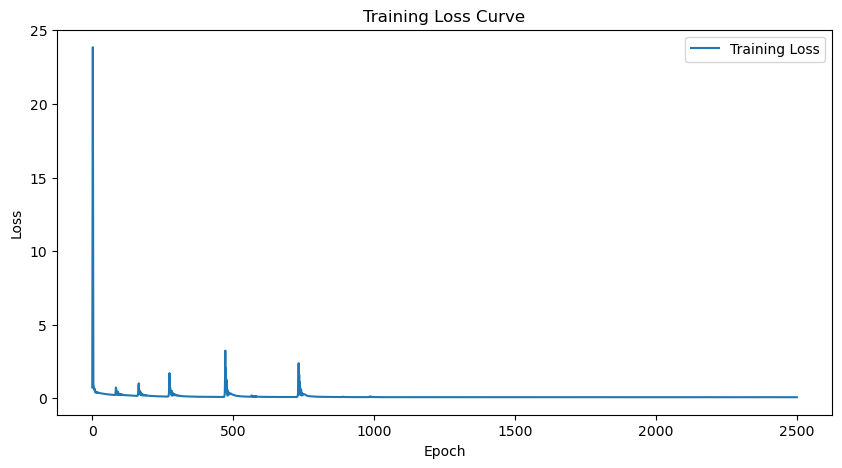

Final Model Accuracy: 77.11%
Final Model F1-score: 0.7862


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.84      0.69      0.75       194
non_infringement       0.72      0.86      0.79       186

        accuracy                           0.77       380
       macro avg       0.78      0.77      0.77       380
    weighted avg       0.78      0.77      0.77       380



/tmp/ipykernel_4057164/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 